### 1. 기본 설정


- 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

- 불러오기 (전처리 전)

In [2]:
file_path = '../lendingClub 대출데이터셋/accepted_2007_to_2018Q4.csv'

# 필요한 컬럼만 (열= 13개)
selected_cols = [
    'loan_status',      # 타겟: 상환 여부
    'annual_inc',        # 연간 소득
    'dti',               # 총부채상환비율 (빚/소득)
    'home_ownership',    # 주거 형태 (자가, 월세 등)
    'fico_range_low',    # 신용점수 하한선
    'revol_util',        # 리볼빙 이용률
    'delinq_2yrs',       # 지난 2년간 30일 이상 연체한 횟수
    'pub_rec',           # 파산 등 공적 기록 횟수
    'loan_amnt',         # 대출 원금
    'int_rate',          # 이자율
    'term',              # 대출 기간
    'purpose',           # 대출 목적
    'grade'             # 신용 등급
]

df = pd.read_csv(file_path, usecols=selected_cols, low_memory=False)

# 행렬 개수 확인
record, columns = df.shape
print(f'행: {record}, 열: {columns}') 

행: 2260701, 열: 13


- 한글 폰트 깨짐 방지

In [3]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스
    plt.rc('font', family='NanumGothic')

# 마이너스 기호방지
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,loan_status,purpose,dti,delinq_2yrs,fico_range_low,pub_rec,revol_util
0,3600.0,36 months,13.99,C,MORTGAGE,55000.0,Fully Paid,debt_consolidation,5.91,0.0,675.0,0.0,29.7
1,24700.0,36 months,11.99,C,MORTGAGE,65000.0,Fully Paid,small_business,16.06,1.0,715.0,0.0,19.2
2,20000.0,60 months,10.78,B,MORTGAGE,63000.0,Fully Paid,home_improvement,10.78,0.0,695.0,0.0,56.2
3,35000.0,60 months,14.85,C,MORTGAGE,110000.0,Current,debt_consolidation,17.06,0.0,785.0,0.0,11.6
4,10400.0,60 months,22.45,F,MORTGAGE,104433.0,Fully Paid,major_purchase,25.37,1.0,695.0,0.0,64.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,40000.0,60 months,10.49,B,MORTGAGE,227000.0,Current,debt_consolidation,12.75,7.0,705.0,0.0,64.9
2260697,24000.0,60 months,14.49,C,RENT,110000.0,Charged Off,debt_consolidation,18.30,0.0,660.0,1.0,68.1
2260698,14000.0,60 months,14.49,C,MORTGAGE,95000.0,Current,debt_consolidation,23.36,0.0,660.0,0.0,54.0
2260699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  2. 데이터 전처리

#### 1. 결측치 처리

- 결측치 확인

In [5]:
df.isnull().sum()

loan_amnt           33
term                33
int_rate            33
grade               33
home_ownership      33
annual_inc          37
loan_status         33
purpose             33
dti               1744
delinq_2yrs         62
fico_range_low      33
pub_rec             62
revol_util        1835
dtype: int64

- 결측치 제거 목록

1. loan_amnt, term, annual_inc **(제거)**

- 근거"데이터의 무결성 확보"
    - 분석 대상이 되는 컬럼(loan_amnt, annual_inc, dti 등)은 부도를 예측하는 핵심 독립변수

2. delinq_2yrs, pub_rec **(0으로 대체)**
- 근거 
    - 신용 조회나 연체기록이 NaN인 경우 시스템상 사항이 없다 0건 일 확률이 높기때문에 0으로 대체 

3. dti, revol_util **(제거)**
- 근거 
    - 해당 컬럼들은 리스크 판단의 핵심 근거로 다른 값으로 채우기엔 위험하며 비율 역시도 굉장히 적기때문에 제거

In [ ]:
# 1. loan_amnt, term, annual_inc
drop_cols = ['loan_amnt', 'term', 'annual_inc']
df.dropna(subset=drop_cols, inplace=True)

# 2. delonq_2yrs, pub_rec 
drop_cols = ['delinq_2yrs', 'pub_rec']
df.dropna(subset=drop_cols, inplace=True)

# 3. dti, revol_util
fill_cols = ['delinq_2yrs', 'pub_rec']
df.fillna({col: 0 for col in fill_cols}, inplace=True) # 0으로 대체
# 확인
df.isnull().sum()

loan_amnt         0
term              0
int_rate          0
grade             0
home_ownership    0
annual_inc        0
loan_status       0
purpose           0
dti               0
delinq_2yrs       0
fico_range_low    0
pub_rec           0
revol_util        0
dtype: int64

#### 2. 이상치 처리

##### 1. dti(소득대비 부채비율)

- 이상치 개수 확인

In [7]:
df.loc[df['dti'] > 100].nunique()

loan_amnt          392
term                 2
int_rate           169
grade                7
home_ownership       4
annual_inc         595
loan_status          6
purpose             11
dti               2154
delinq_2yrs         13
fico_range_low      38
pub_rec              5
revol_util         882
dtype: int64

- DTI 이상치 제거(음수 제거, 100 상한선)

- 근거
    - 음수 제거: 부채 상환액이나 소득은 음수가 될 수 없기때문에 

    - 100% 상한선: DTI가 100을 넘는다는 것은 매달 갚아야 할 빚이 월 소득보다 많다는 의미로 제거

In [ ]:
# DTI가 100 이상인 행을 제거
df = df[df['dti'] < 100]

# 잘 제거되었는지 확인
print(f"제거후 100 이상: {df[df['dti'] >= 100].shape[0]}개")

제거후 100 이상: 0개


#####  2. annual_income (연간소득)

- 연간 소득분포 산점도로 확인

- 비정상적인 값 두개 발견 (연소득 1억달러 이상, 6천만 달러 이상)

- annual_inc 1000만 이상 제거 

- 근거
    - 해당 (두개)의 값을 제외한 최댓값이 1000만 달러 미만이므로 이상치로 판단하여 제거

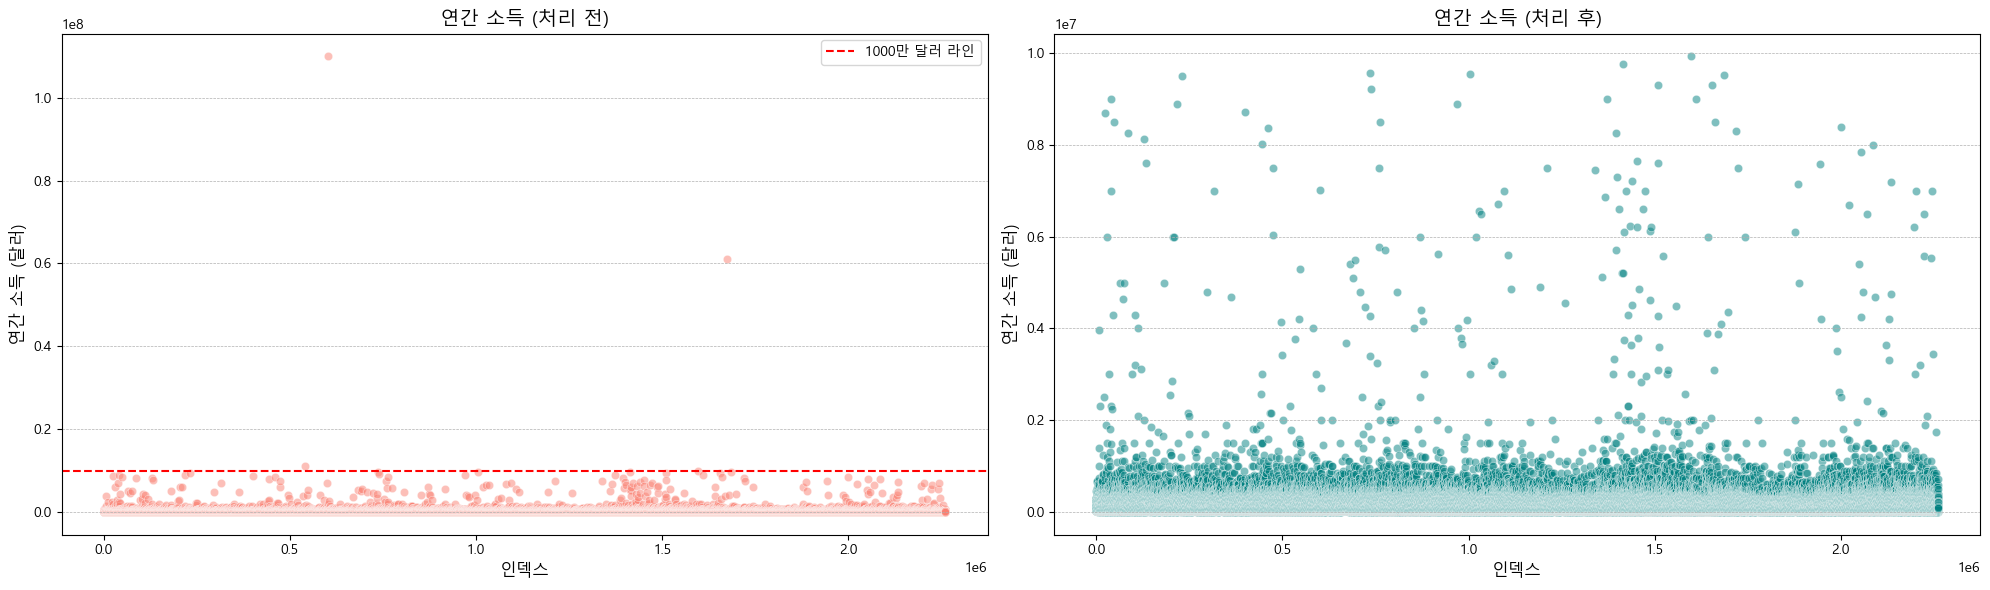

현재 연소득 최대값: $9,930,475


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

### 왼쪽 산점도 (이상치 처리 전)
sns.scatterplot(x=df.index, y=df['annual_inc'], 
                alpha=0.5, color='salmon', ax=axes[0]) # ax=axes[0] : 첫 번째 칸에 그림

axes[0].set_title('연간 소득 (처리 전)', fontsize=14)
axes[0].set_ylabel('연간 소득 (달러)', fontsize=12)
axes[0].set_xlabel('인덱스', fontsize=12)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# 잘려나갈 기준선(1,000만 달러) 표시
axes[0].axhline(10000000, color='red', linestyle='--', label='1000만 달러 라인')
axes[0].legend()

### 이상치 처리 
df_filtered = df[df['annual_inc'] <= 10000000]


###  오른쪽 산점도 (이상치 처리 후)
sns.scatterplot(x=df_filtered.index, y=df_filtered['annual_inc'], 
                alpha=0.5, color='teal', ax=axes[1]) # ax=axes[1] : 두 번째 칸에 그림

axes[1].set_title('연간 소득 (처리 후)', fontsize=14)
axes[1].set_ylabel('연간 소득 (달러)', fontsize=12)
axes[1].set_xlabel('인덱스', fontsize=12)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

plt.tight_layout() # 그래프간 간격 조정용도
plt.show()

# 전처리 확인
print(f"현재 연소득 최대값: ${df_filtered['annual_inc'].max():,.0f}")

# 다시 df로 돌리기
df = df_filtered


##### 3. revol_util (신용한도 사용률)

- 전체 데이터 횟수, 110% 이상, 120% 이상 횟수 확인

In [10]:
# 전체 데이터 개수
total_count = len(df)

# 100% 이상
over_100 = len(df[df['revol_util'] > 100])
pct_over_100 = (over_100 / total_count) * 100 # 비율 확인용

# 110% 이상
over_200 = len(df[df['revol_util'] > 110])
pct_over_200 = (over_200 / total_count) * 100

print(f"revol_util 전체 데이터 (총 {total_count:,}건)")
print(f"100% 초과 : {over_100:,}건 ({pct_over_100:.2f}%)")
print(f"110% 초과 : {over_200:,}건 ({pct_over_200:.4f}%)")

revol_util 전체 데이터 (총 2,254,591건)
100% 초과 : 7,329건 (0.33%)
110% 초과 : 506건 (0.0224%)


- 산점도로 확인

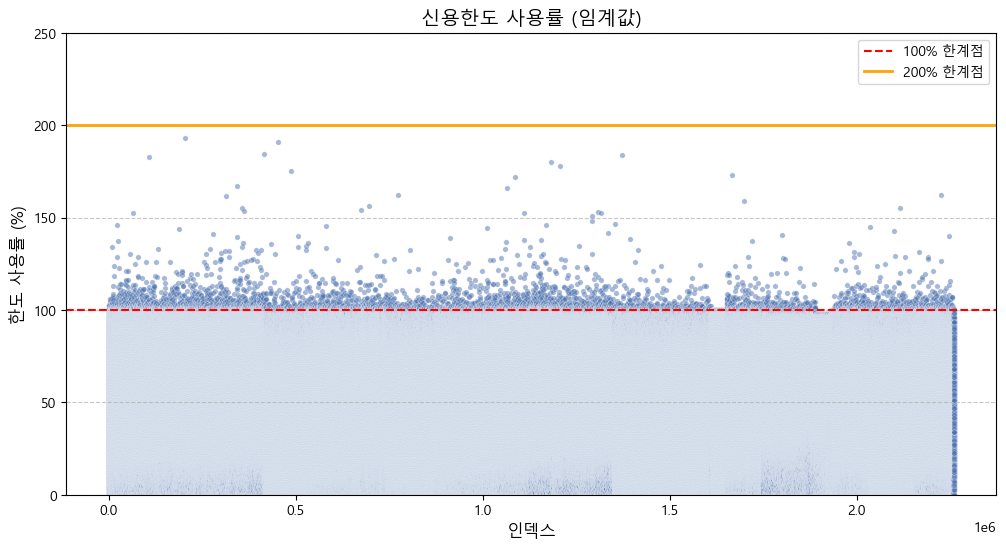

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df.index, y=df['revol_util'], alpha=0.5, s=15, color='#4c72b0') # 헥스 코드

# 빨간선 (100%)
plt.axhline(100, color='red', linestyle='--', linewidth=1.5, label='100% 지점')
# 주황선 (200%)
plt.axhline(200, color='orange', linestyle='-', linewidth=2, label='200% 지점')

plt.title('신용한도 사용률 (임계값)', fontsize=14)
plt.ylabel('한도 사용률 (%)', fontsize=12)
plt.xlabel('인덱스', fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# y축 위의 값들을 확인
plt.ylim(0, 250)
plt.show()

- 200% 이상 데이터는 2개로 각각 366.6 , 892.3 이라는 비정상적인 수치 

- 110% 이상 데이터는 504건으로 100% 와 110% 사이에 대부분의 값들이 포진하고있음

In [12]:
# 110% 이상인 이상치 데이터 필터링
util_df = df[df['revol_util'] > 110]

# 데이터 개수 확인
print(f"전체 데이터 개수: {len(df)}")
print(f"200% 이상 데이터 개수: {len(util_df)}")
print(f"전체 대비 비중: {len(util_df) / len(df) * 100:.2f}%")

# 상위 5개 내림차순으로 확인(2개있음) 
util_df.sort_values(by='revol_util', ascending=False).head(5)

전체 데이터 개수: 2254591
200% 이상 데이터 개수: 506
전체 대비 비중: 0.02%


,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,loan_status,purpose,dti,delinq_2yrs,fico_range_low,pub_rec,revol_util
1292903,3500.0,36 months,12.49,B,RENT,45000.0,Fully Paid,debt_consolidation,14.67,0.0,695.0,0.0,892.3
1254597,16500.0,60 months,14.49,C,MORTGAGE,48000.0,Charged Off,debt_consolidation,9.33,0.0,715.0,0.0,366.6
205263,35000.0,36 months,16.99,D,MORTGAGE,175000.0,Fully Paid,debt_consolidation,5.18,0.0,670.0,0.0,193.0
451909,20000.0,36 months,11.98,B,MORTGAGE,66000.0,Current,credit_card,13.01,0.0,675.0,0.0,191.0
414612,28000.0,36 months,12.99,C,MORTGAGE,200000.0,Fully Paid,credit_card,15.61,1.0,675.0,0.0,184.6


- 이상치 처리 신용한도 사용률(revol_util)이 110% 이상인 데이터만 삭제

- 근거 

     - 신용카드 한도를 100% 초과해서 쓰는 '오버 리밋(Over-limit)'은 실제 금융 시장에서 초고위험군을 나타내는 중요한 신호

        a. 연체 및 이자 누적: 이미 한도를 꽉 채워 썼는데, 연체 이자나 수수료가 붙으면서 잔액(Balance)이 한도(Limit)를 초과한 경우.

        b. 한도 초과 승인 (Over-limit): 카드사 정책에 따라 일시적으로 한도를 초과하여 결제가 승인되는 경우.

        c. 신용 한도 축소: 카드를 쓰는 도중에 신용도가 하락하여 은행이 한도를 줄여버린 경우 (분모가 작아져서 비율이 급등).

      100%에서 10%정도를 오차로 두고 110%를 넘어서는 이상치로 판별하기로 결정

In [13]:
# 신용한도(revol_util) 110% 이상 삭제
df = df[df['revol_util'] <= 110]

# 100% 이상
over_100 = len(df[df['revol_util'] > 100])
pct_over_100 = (over_100 / total_count) * 100 # 여기는 비율 확인용

# 110% 이상
over_200 = len(df[df['revol_util'] > 110])
pct_over_200 = (over_200 / total_count) * 100 # 여기는 비율 확인용

print(f"revol_util 전체 데이터 (총 {total_count:,}건)")
print(f"100% 초과 : {over_100:,}건 ({pct_over_100:.2f}%)")
print(f'110% 초과: {over_200:,}건 ({pct_over_200:.2f}%)')

revol_util 전체 데이터 (총 2,254,591건)
100% 초과 : 6,823건 (0.30%)
110% 초과: 0건 (0.00%)


##### 4. peb_rec (공공 기록)

- 수치로 확인

In [14]:
print(df['pub_rec'].quantile([0.95, 0.99, 0.995, 0.999, 1.0])) 

# 99.5% 이상값
limit = df['pub_rec'].quantile(0.995) 
count_over = len(df[df['pub_rec'] > limit]) 

print(f"99.5% 기준값: {limit}회") 
print(f"이 값을 넘는 이상치 개수: {count_over}개 (전체의 {count_over/len(df)*100:.2f}%)")

0.950     1.0
0.990     2.0
0.995     3.0
0.999     5.0
1.000    86.0
Name: pub_rec, dtype: float64
99.5% 기준값: 3.0회
이 값을 넘는 이상치 개수: 7763개 (전체의 0.34%)


- 바플롯(bar_plot)으로 확인 --> 히스토그램

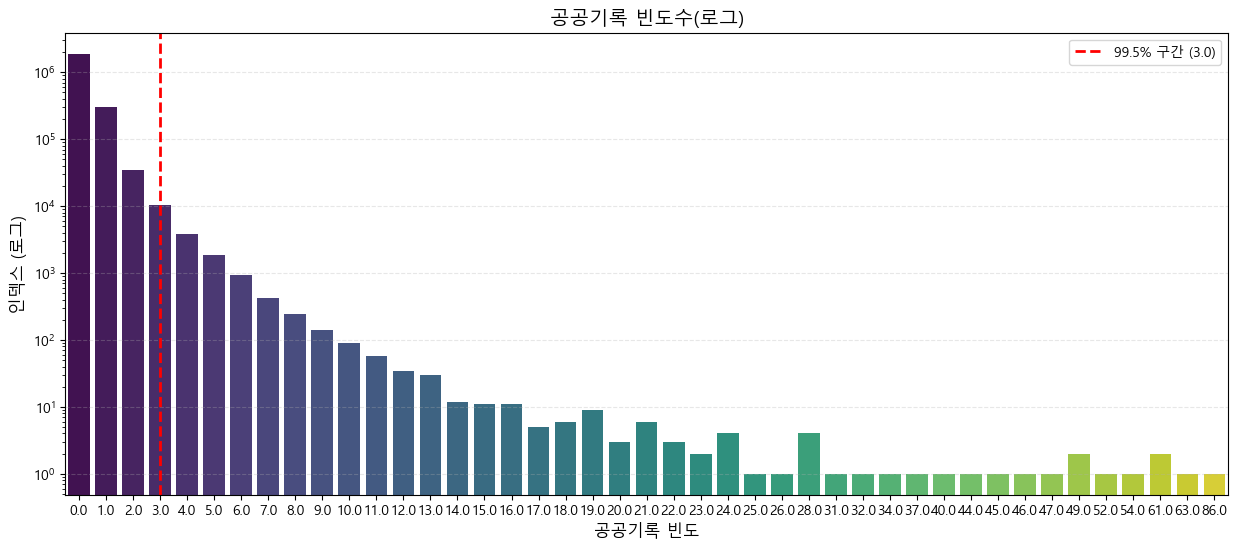

In [15]:
pub_rec_counts = df['pub_rec'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
pub_rec_plot = sns.barplot(x=pub_rec_counts.index, y=pub_rec_counts.values, palette='viridis')

# y스케일을 로그로해야 잘 보이기때문에 축소 
plt.yscale('log')

# 기준선 99.5 
limit_995 = df['pub_rec'].quantile(0.995)
plt.axvline(x=limit_995, color='red', linestyle='--', linewidth=2, label=f'99.5% 구간 ({limit_995})')

plt.title('공공기록 빈도수(로그)', fontsize=14)
plt.xlabel('공공기록 빈도', fontsize=12)
plt.ylabel('인덱스 (로그)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

- 상위 99.5%값으로 클리핑

- 근거 
    - 대부분의 데이터가 0과 1에 몰려 있는데, 혼자 '86'이라는 값을 가진 데이터가 들어가면 
    - 모델은 이 값에 과도하게 영향을 받아 가중치(Weight)가 비정상적으로 틀어지게 되므로, 이를 방지하기 위해 상위 0.5%의 극단값을 제거

In [16]:
# 1. Pub_rec: 상위 99.5% 값으로 클리핑
limit_995 = df['pub_rec'].quantile(0.995) # 분위수(0.995)
df['pub_rec'] = df['pub_rec'].clip(upper=limit_995)
print(f"pub_rec 상한선 적용값: {limit_995}회") # 횟수 확인

pub_rec 상한선 적용값: 3.0회


- 이상치 제거 확인

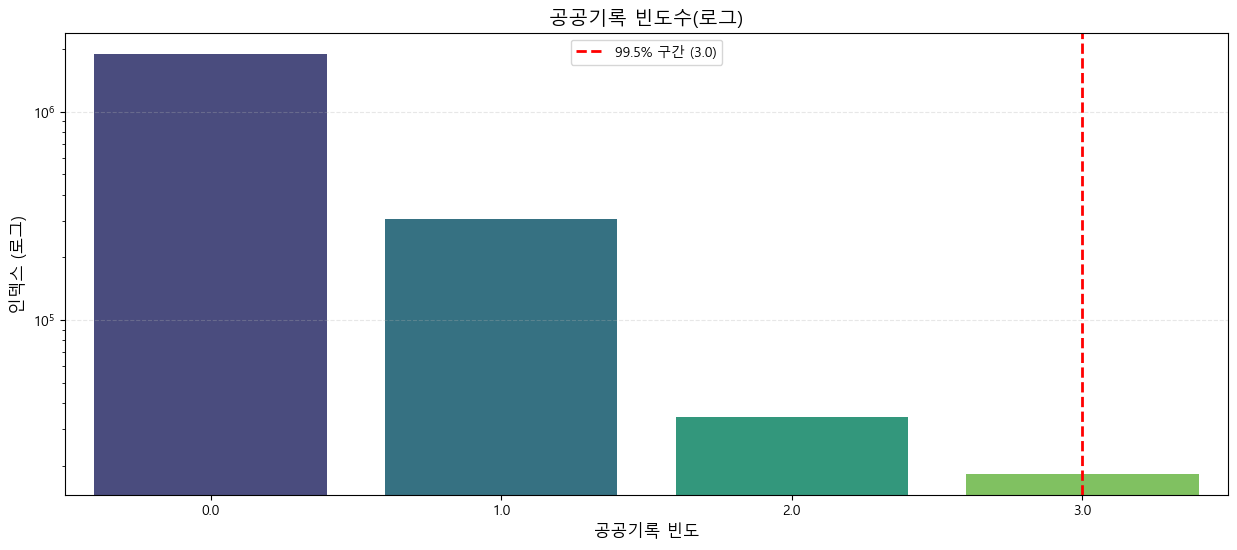

In [17]:
pub_rec_counts = df['pub_rec'].value_counts().sort_index()

plt.figure(figsize=(15, 6))

# 바플롯(bar)
pub_rec_plot = sns.barplot(x=pub_rec_counts.index, y=pub_rec_counts.values, palette='viridis')

# y스케일을 로그로해야 잘 보인다고하네요
plt.yscale('log')

# 기준선은 99.5
limit_995 = df['pub_rec'].quantile(0.995)
# 약간의 보정
plt.axvline(x=limit_995, color='red', linestyle='--', linewidth=2, label=f'99.5% 구간 ({limit_995})')


plt.title('공공기록 빈도수(로그)', fontsize=14)
plt.xlabel('공공기록 빈도', fontsize=12)
plt.ylabel('인덱스 (로그)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

In [18]:
# 전처리완료 폴더에 저장 (폴더 위치 다를 수 있음)
df.to_csv('../전처리 완료/lendingclub 전처리 완료.csv', index=False)

print("저장완료")

저장완료
